<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/5.%20Modelling/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Other Libraries
from scipy.stats import mstats
import copy
import tqdm

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 240)

# Plotting Function
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 2.5))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# Scorer Functions
def sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    return sensitivity

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    return specificity

def auroc_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def aucpr_scorer(y_true, y_pred):
    return average_precision_score(y_true, y_pred)

sensitivity_scorer = make_scorer(sensitivity)
specificity_scorer = make_scorer(specificity)
auroc_scorer = make_scorer(auroc_scorer)
aucpr_scorer = make_scorer(aucpr_scorer)

# Scorer Functions for Neural Network
def calculate_sensitivity(y_true, y_pred):
    true_positive = torch.logical_and(y_true == 1, y_pred == 1).sum().item()
    actual_positive = (y_true == 1).sum().item()
    sensitivity = true_positive / actual_positive if actual_positive != 0 else 0
    return sensitivity

def calculate_specificity(y_true, y_pred):
    true_negative = torch.logical_and(y_true == 0, y_pred == 0).sum().item()
    actual_negative = (y_true == 0).sum().item()
    specificity = true_negative / actual_negative if actual_negative != 0 else 0
    return specificity

def calculate_auroc_scorer(y_true, y_pred):
    return roc_auc_score(y_true.detach().numpy(), y_pred.detach().numpy())

def calculate_aucpr_scorer(y_true, y_pred):
    return average_precision_score(y_true.detach().numpy(), y_pred.detach().numpy())

# Winsorization class for pipelines
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, lower=0.01, upper=0.99):
        self.columns = columns
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        if self.columns is not None:
            for col in self.columns:
                if col in X_copy.columns:
                    X_copy[col] = mstats.winsorize(X_copy[col], limits=[self.lower, self.upper])
        else:
            for col in X_copy.columns:
                X_copy[col] = mstats.winsorize(X_copy[col], limits=[self.lower, self.upper])

        return X_copy

In [2]:
# !wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/clean_data.csv' -O clean_data.csv

data = pd.read_csv('modelling_data.csv')
data.shape

(780, 52)

In [3]:
# Defining Feature Sets

extreme_outlier = [
    "BMI",
    "Body_Temperature",
    'RBC_Count',
    'Hemoglobin', 
    'RDW',
    'Thrombocyte_Count'
]


restricted = [
    "Length_of_Stay",
    "Alvarado_Score",
    "Ipsilateral_Rebound_Tenderness",
    "Paedriatic_Appendicitis_Score",
    "Peritonitis"
]


partially_restricted = [
    "Length_of_Stay",
    "Alvarado_Score",
    "CRP",
    "Ipsilateral_Rebound_Tenderness",
    "WBC_Count",
    "Paedriatic_Appendicitis_Score",
    "Peritonitis",
    "Neutrophil_Percentage",
    "Segmented_Neutrophils"
]

unrestricted = [
    'Appendix_Diameter', 
    'Length_of_Stay', 
    'Alvarado_Score', 
    'Surrounding_Tissue_Reaction',
    'WBC_Count',
    'Appendix_on_US',
    'Ipsilateral_Rebound_Tenderness',
    'CRP',
    'Segmented_Neutrophils',
    'Peritonitis',
    'Neutrophil_Percentage',
    'Paedriatic_Appendicitis_Score'
    
]

complete = ['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW',
       'Thrombocyte_Count', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign',
       'Appendicolith', 'Perfusion', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Pathological_Lymph_Nodes', 'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism',
       'Enteritis', 'Gynecological_Findings']

TARGET = "Diagnosis"

sets = [restricted, partially_restricted, unrestricted, complete]
set_names = [
    "Restricted Dataset: Subset of Demographic + Scoring + Clinical",
    "Partially Restricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory",
    "Unrestricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory + Ultrasound",
    "Complete Dataset: all variables"
            ]

## Logistic Regression

Restricted Dataset: Subset of Demographic + Scoring + Clinical
Accuracy: 	 0.742 (± 0.03 )
ROC: 	 	 0.737 (± 0.03 )
AUCPR: 	 	 0.749 (± 0.03 )
Sensitivy: 	 0.758 (± 0.04 )
Specificity: 	 0.716 (± 0.00 )
 


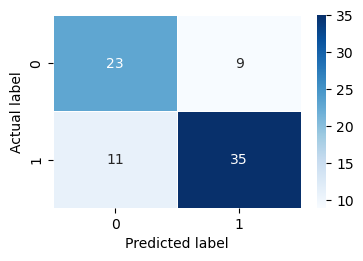

Partially Restricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.751 (± 0.03 )
ROC: 	 	 0.745 (± 0.03 )
AUCPR: 	 	 0.754 (± 0.03 )
Sensitivy: 	 0.776 (± 0.03 )
Specificity: 	 0.715 (± 0.00 )
 


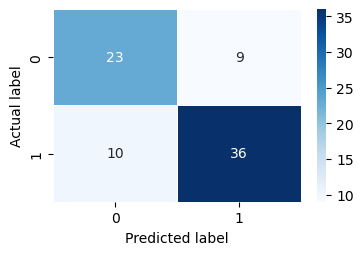

Unrestricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.903 (± 0.04 )
ROC: 	 	 0.901 (± 0.05 )
AUCPR: 	 	 0.901 (± 0.03 )
Sensitivy: 	 0.907 (± 0.04 )
Specificity: 	 0.895 (± 0.00 )
 


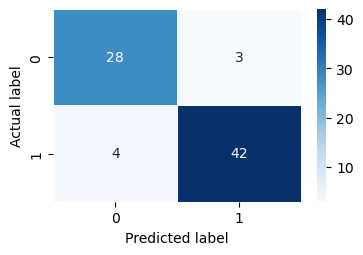

Complete Dataset: all variables
Accuracy: 	 0.900 (± 0.03 )
ROC: 	 	 0.897 (± 0.04 )
AUCPR: 	 	 0.895 (± 0.03 )
Sensitivy: 	 0.905 (± 0.04 )
Specificity: 	 0.889 (± 0.00 )
 


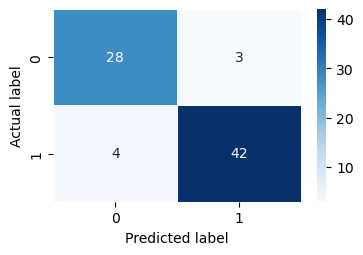

In [4]:
lr_results = []

lr_accuracy = []
lr_auroc = []
lr_aucpr = []
lr_sensitivity = []
lr_specificity = []

lr_accuracy_sd = []
lr_auroc_sd = []
lr_aucpr_sd = []
lr_sensitivity_sd = []
lr_specificity_sd = []


for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]
    
    # Model & pipeline
    lr_model = LogisticRegression(max_iter=1000, random_state=123)

    lr_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=26)),
        ('classifier', lr_model)
    ])

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores
    # Confusion Matrix
    y_pred_cv = cross_val_predict(lr_pipeline, X, y, cv=k_fold)
    cm_lr = confusion_matrix(y, y_pred_cv)
    cm_lr = cm_lr / splits
    cm_lr = np.round(cm_lr,0)
    cm_lr = cm_lr.astype(int)

    # Accuracy
    cv_scores_accuracy = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    lr_accuracy.append(mean_cv_accuracy)
    lr_accuracy_sd.append(sd_cv_accuracy)
    lr_results.append(mean_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    lr_auroc.append(mean_cv_auroc)
    lr_auroc_sd.append(sd_cv_auroc)
    lr_results.append(mean_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    lr_aucpr.append(mean_cv_aucpr)
    lr_aucpr_sd.append(sd_cv_aucpr)
    lr_results.append(mean_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    lr_sensitivity.append(mean_cv_sensitivity)
    lr_sensitivity_sd.append(sd_cv_sensitivity)
    lr_results.append(mean_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    lr_specificity.append(mean_cv_specificity)
    lr_specificity_sd.append(sd_cv_specificity)
    lr_results.append(mean_cv_specificity)

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_lr, "")

## Naive Bayes Classifier

Restricted Dataset: Subset of Demographic + Scoring + Clinical
Accuracy: 	 0.736 (± 0.03 )
ROC: 	 	 0.748 (± 0.03 )
AUCPR: 	 	 0.765 (± 0.04 )
Sensitivy: 	 0.677 (± 0.04 )
Specificity: 	 0.819 (± 0.00 )
 


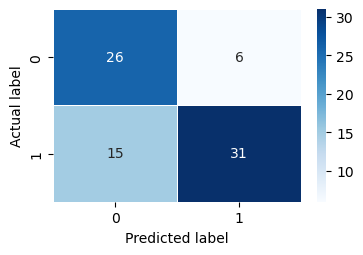

Partially Restricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.733 (± 0.04 )
ROC: 	 	 0.743 (± 0.05 )
AUCPR: 	 	 0.762 (± 0.04 )
Sensitivy: 	 0.684 (± 0.05 )
Specificity: 	 0.802 (± 0.00 )
 


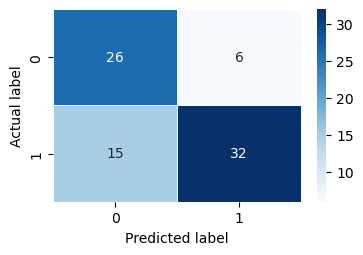

Unrestricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.824 (± 0.06 )
ROC: 	 	 0.827 (± 0.07 )
AUCPR: 	 	 0.836 (± 0.06 )
Sensitivy: 	 0.806 (± 0.04 )
Specificity: 	 0.847 (± 0.00 )
 


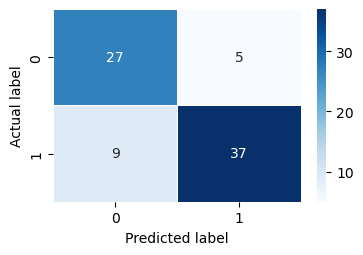

Complete Dataset: all variables
Accuracy: 	 0.690 (± 0.05 )
ROC: 	 	 0.731 (± 0.04 )
AUCPR: 	 	 0.772 (± 0.04 )
Sensitivy: 	 0.511 (± 0.07 )
Specificity: 	 0.951 (± 0.00 )
 


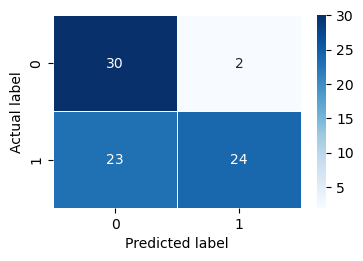

In [5]:
nb_results = []

nb_accuracy = []
nb_auroc = []
nb_aucpr = []
nb_sensitivity = []
nb_specificity = []

nb_accuracy_sd = []
nb_auroc_sd = []
nb_aucpr_sd = []
nb_sensitivity_sd = []
nb_specificity_sd = []

for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]

    # Model & pipeline
    nb_model = GaussianNB()

    nb_pipeline = Pipeline([
        ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=26)),
        ('classifier', nb_model)
    ])

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores
    # Confusion Matrix
    y_pred_cv = cross_val_predict(nb_pipeline, X, y, cv=k_fold)
    cm_nb = confusion_matrix(y, y_pred_cv)
    cm_nb = cm_nb / splits
    cm_nb = np.round(cm_nb,0)
    cm_nb = cm_nb.astype(int)

    # Accuracy
    cv_scores_accuracy = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    nb_accuracy.append(mean_cv_accuracy)
    nb_accuracy_sd.append(sd_cv_accuracy)
    nb_results.append(mean_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    nb_auroc.append(mean_cv_auroc)
    nb_auroc_sd.append(sd_cv_auroc)
    nb_results.append(mean_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    nb_aucpr.append(mean_cv_aucpr)
    nb_aucpr_sd.append(sd_cv_aucpr)
    nb_results.append(mean_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    nb_sensitivity.append(mean_cv_sensitivity)
    nb_sensitivity_sd.append(sd_cv_sensitivity)
    nb_results.append(mean_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    nb_specificity.append(mean_cv_specificity)
    nb_specificity_sd.append(sd_cv_specificity)
    nb_results.append(mean_cv_specificity)

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_nb, "")

## Support Vector Machine

Restricted Dataset: Subset of Demographic + Scoring + Clinical
Accuracy: 	 0.744 (± 0.03 )
ROC: 	 	 0.743 (± 0.04 )
AUCPR: 	 	 0.756 (± 0.04 )
Sensitivy: 	 0.741 (± 0.04 )
Specificity: 	 0.746 (± 0.00 )
 


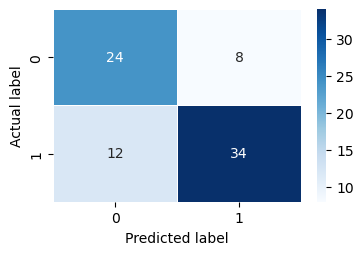

Partially Restricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.740 (± 0.03 )
ROC: 	 	 0.725 (± 0.03 )
AUCPR: 	 	 0.736 (± 0.03 )
Sensitivy: 	 0.805 (± 0.04 )
Specificity: 	 0.646 (± 0.00 )
 


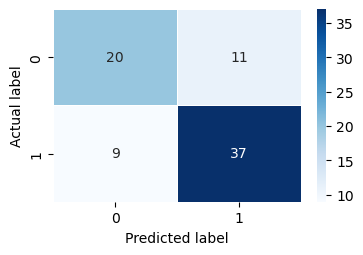

Unrestricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.912 (± 0.03 )
ROC: 	 	 0.908 (± 0.04 )
AUCPR: 	 	 0.906 (± 0.03 )
Sensitivy: 	 0.921 (± 0.04 )
Specificity: 	 0.895 (± 0.00 )
 


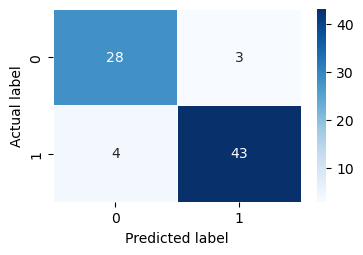

Complete Dataset: all variables
Accuracy: 	 0.678 (± 0.14 )
ROC: 	 	 0.617 (± 0.16 )
AUCPR: 	 	 0.673 (± 0.14 )
Sensitivy: 	 0.977 (± 0.03 )
Specificity: 	 0.257 (± 0.00 )
 


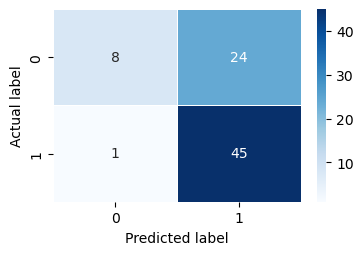

In [6]:
svm_results = []

svm_accuracy = []
svm_auroc = []
svm_aucpr = []
svm_sensitivity = []
svm_specificity = []

svm_accuracy_sd = []
svm_auroc_sd = []
svm_aucpr_sd = []
svm_sensitivity_sd = []
svm_specificity_sd = []

for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]

    # Model & pipeline
    svm_model = SVC(kernel='rbf', random_state=123, probability=True)

    svm_pipeline = Pipeline([
        ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=26)),
        ('classifier', svm_model)
    ])

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores
    # Confusion Matrix
    y_pred_cv = cross_val_predict(svm_pipeline, X, y, cv=k_fold)
    cm_svm = confusion_matrix(y, y_pred_cv)
    cm_svm = cm_svm / splits
    cm_svm = np.round(cm_svm,0)
    cm_svm = cm_svm.astype(int)

    # Accuracy
    cv_scores_accuracy = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    svm_accuracy.append(mean_cv_accuracy)
    svm_accuracy_sd.append(sd_cv_accuracy)
    svm_results.append(mean_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    svm_auroc.append(mean_cv_auroc)
    svm_auroc_sd.append(sd_cv_auroc)
    svm_results.append(mean_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    svm_aucpr.append(mean_cv_aucpr)
    svm_aucpr_sd.append(sd_cv_aucpr)
    svm_results.append(mean_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    svm_sensitivity.append(mean_cv_sensitivity)
    svm_sensitivity_sd.append(sd_cv_sensitivity)
    svm_results.append(mean_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    svm_specificity.append(mean_cv_specificity)
    svm_specificity_sd.append(sd_cv_specificity)
    svm_results.append(mean_cv_specificity)

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_svm, "")

## Random Forest Classifier

Restricted Dataset: Subset of Demographic + Scoring + Clinical
Accuracy: 	 0.741 (± 0.04 )
ROC: 	 	 0.737 (± 0.03 )
AUCPR: 	 	 0.747 (± 0.04 )
Sensitivy: 	 0.758 (± 0.07 )
Specificity: 	 0.716 (± 0.00 )
 


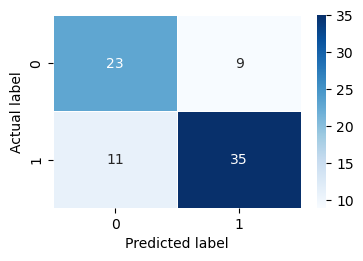

Partially Restricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.726 (± 0.03 )
ROC: 	 	 0.716 (± 0.04 )
AUCPR: 	 	 0.730 (± 0.03 )
Sensitivy: 	 0.763 (± 0.04 )
Specificity: 	 0.670 (± 0.00 )
 


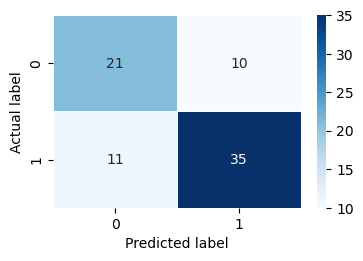

Unrestricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.945 (± 0.04 )
ROC: 	 	 0.942 (± 0.04 )
AUCPR: 	 	 0.942 (± 0.04 )
Sensitivy: 	 0.952 (± 0.03 )
Specificity: 	 0.933 (± 0.00 )
 


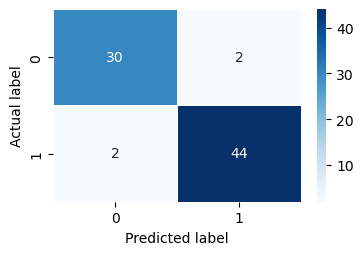

Complete Dataset: all variables
Accuracy: 	 0.937 (± 0.03 )
ROC: 	 	 0.936 (± 0.04 )
AUCPR: 	 	 0.934 (± 0.03 )
Sensitivy: 	 0.941 (± 0.04 )
Specificity: 	 0.932 (± 0.00 )
 


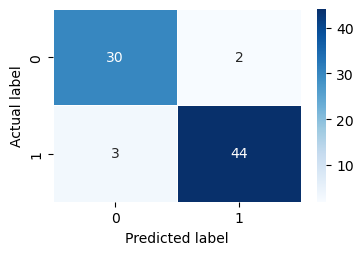

In [7]:
rf_results = []

rf_accuracy = []
rf_auroc = []
rf_aucpr = []
rf_sensitivity = []
rf_specificity = []

rf_accuracy_sd = []
rf_auroc_sd = []
rf_aucpr_sd = []
rf_sensitivity_sd = []
rf_specificity_sd = []

for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]

    # Model & pipeline
    rf_model = RandomForestClassifier(n_estimators=100, random_state=123)

    rf_pipeline = Pipeline([
        ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=26)),
        ('classifier', rf_model)
    ])

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores
    # Confusion Matrix
    y_pred_cv = cross_val_predict(rf_pipeline, X, y, cv=k_fold)
    cm_rf = confusion_matrix(y, y_pred_cv)
    cm_rf = cm_rf / splits
    cm_rf = np.round(cm_rf,0)
    cm_rf = cm_rf.astype(int)

    # Accuracy
    cv_scores_accuracy = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    rf_accuracy.append(mean_cv_accuracy)
    rf_accuracy_sd.append(sd_cv_accuracy)
    rf_results.append(mean_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    rf_auroc.append(mean_cv_auroc)
    rf_auroc_sd.append(sd_cv_auroc)
    rf_results.append(mean_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    rf_aucpr.append(mean_cv_aucpr)
    rf_aucpr_sd.append(sd_cv_aucpr)
    rf_results.append(mean_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    rf_sensitivity.append(mean_cv_sensitivity)
    rf_sensitivity_sd.append(sd_cv_sensitivity)
    rf_results.append(mean_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    rf_specificity.append(mean_cv_specificity)
    rf_specificity_sd.append(sd_cv_specificity)
    rf_results.append(mean_cv_specificity)

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_rf, "")

## Gradient Boosting Classifier

Restricted Dataset: Subset of Demographic + Scoring + Clinical
Accuracy: 	 0.750 (± 0.04 )
ROC: 	 	 0.754 (± 0.04 )
AUCPR: 	 	 0.767 (± 0.04 )
Sensitivy: 	 0.725 (± 0.05 )
Specificity: 	 0.783 (± 0.00 )
 


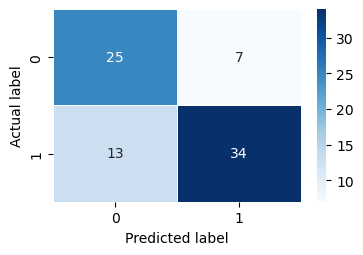

Partially Restricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.745 (± 0.03 )
ROC: 	 	 0.735 (± 0.03 )
AUCPR: 	 	 0.745 (± 0.04 )
Sensitivy: 	 0.779 (± 0.05 )
Specificity: 	 0.691 (± 0.00 )
 


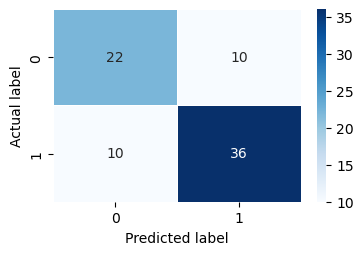

Unrestricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.950 (± 0.03 )
ROC: 	 	 0.948 (± 0.03 )
AUCPR: 	 	 0.947 (± 0.03 )
Sensitivy: 	 0.956 (± 0.02 )
Specificity: 	 0.941 (± 0.00 )
 


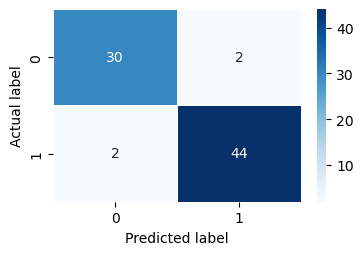

Complete Dataset: all variables
Accuracy: 	 0.950 (± 0.03 )
ROC: 	 	 0.949 (± 0.03 )
AUCPR: 	 	 0.950 (± 0.03 )
Sensitivy: 	 0.949 (± 0.02 )
Specificity: 	 0.949 (± 0.00 )
 


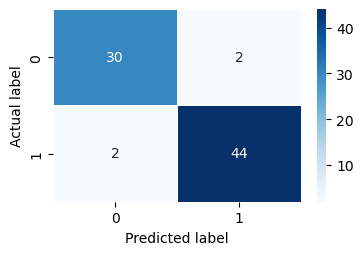

In [8]:
gb_results = []

gb_accuracy = []
gb_auroc = []
gb_aucpr = []
gb_sensitivity = []
gb_specificity = []

gb_accuracy_sd = []
gb_auroc_sd = []
gb_aucpr_sd = []
gb_sensitivity_sd = []
gb_specificity_sd = []

for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]

    # Model & pipeline
    gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=123)

    gbm_pipeline = Pipeline([
        ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=26)),
        ('classifier', gbm_model)
    ])

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores
    # Confusion Matrix
    y_pred_cv = cross_val_predict(gbm_pipeline, X, y, cv=k_fold)
    cm_gbm = confusion_matrix(y, y_pred_cv)
    cm_gbm = cm_gbm / splits
    cm_gbm = np.round(cm_gbm,0)
    cm_gbm = cm_gbm.astype(int)

    # Accuracy
    cv_scores_accuracy = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    gb_accuracy.append(mean_cv_accuracy)
    gb_accuracy_sd.append(sd_cv_accuracy)
    gb_results.append(mean_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    gb_auroc.append(mean_cv_auroc)
    gb_auroc_sd.append(sd_cv_auroc)
    gb_results.append(mean_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    gb_aucpr.append(mean_cv_aucpr)
    gb_aucpr_sd.append(sd_cv_aucpr)
    gb_results.append(mean_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    gb_sensitivity.append(mean_cv_sensitivity)
    gb_sensitivity_sd.append(sd_cv_sensitivity)
    gb_results.append(mean_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    gb_specificity.append(mean_cv_specificity)
    gb_specificity_sd.append(sd_cv_specificity)
    gb_results.append(mean_cv_specificity)

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_gbm, "")

## Neural Network

In [10]:
nn_results = []

nn_accuracy = []
nn_auroc = []
nn_aucpr = []
nn_sensitivity = []
nn_specificity = []

nn_accuracy_sd = []
nn_auroc_sd = []
nn_aucpr_sd = []
nn_sensitivity_sd = []
nn_specificity_sd = []

for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]

    # Pipeline
    nn_pipeline = Pipeline([
        ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=26))
    ])

    # Using the pipeline for X and creating tensors
    X_nn = nn_pipeline.fit_transform(X)

    X_nn = torch.tensor(X_nn, dtype=torch.float32)
    y_nn = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

    # Model
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.hidden = nn.Linear(X.shape[1], 128)
            self.relu = nn.ReLU()
            self.layer2 = nn.Linear(128, 64)
            self.act2 = nn.ReLU()
            self.output = nn.Linear(64, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.hidden(x))
            x = self.act2(self.layer2(x))
            x = self.sigmoid(self.output(x))
            return x

    def model_train(model, X_train, y_train, X_val, y_val):

        # Loss function (binary cross entropy) and optimizer
        loss_func = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        n_epochs = 50
        batch_size = 10
        batch_start = torch.arange(0, len(X_train), batch_size)

        best_acc = -np.inf
        best_weights = None
        best_sensitivity = 0
        best_specificity = 0
        best_auroc = 0
        best_aucpr = 0

        for epoch in range(n_epochs):
            model.train()
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # take a batch
                    X_batch = X_train[start:start+batch_size]
                    y_batch = y_train[start:start+batch_size]
                    # forward pass
                    y_pred = model(X_batch)
                    loss = loss_func(y_pred, y_batch)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # print progress
                    acc = (y_pred.round() == y_batch).float().mean()
                    bar.set_postfix(
                        loss=float(loss),
                        acc=float(acc)
                    )
            # evluating after each epoch
            model.eval()
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            sensitivity = calculate_sensitivity(y_val, y_pred.round())
            specificity = calculate_specificity(y_val, y_pred.round())
            auroc = calculate_auroc_scorer(y_val, y_pred)
            aucpr = calculate_aucpr_scorer(y_val, y_pred)

            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
                best_sensitivity = sensitivity
                best_specificity = specificity
                best_auroc = auroc
                best_aucpr = aucpr

        # restore model and return best accuracy, sensitivity, specificity, AUROC, and AUCPR
        model.load_state_dict(best_weights)
        return best_acc, best_auroc, best_aucpr, best_sensitivity, best_specificity

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)
    cv_scores_accuracy = []
    cv_scores_auroc = []
    cv_scores_aucpr = []
    cv_scores_sensitivity = []
    cv_scores_specificity = []

    for train, test in k_fold.split(X_nn, y_nn):
        model = NeuralNetwork()
        results = model_train(model, X_nn[train], y_nn[train], X_nn[test], y_nn[test])
        cv_scores_accuracy.append(results[0])
        cv_scores_auroc.append(results[1])
        cv_scores_aucpr.append(results[2])
        cv_scores_sensitivity.append(results[3])
        cv_scores_specificity.append(results[4])


    nn_accuracy.append(np.mean(cv_scores_accuracy))
    nn_accuracy_sd.append(np.std(cv_scores_accuracy))
    nn_results.append(np.mean(cv_scores_accuracy))

    nn_auroc.append(np.mean(cv_scores_auroc))
    nn_auroc_sd.append(np.std(cv_scores_auroc))
    nn_results.append(np.mean(cv_scores_auroc))

    nn_aucpr.append(np.mean(cv_scores_aucpr))
    nn_aucpr_sd.append(np.std(cv_scores_aucpr))
    nn_results.append(np.mean(cv_scores_aucpr))

    nn_sensitivity.append(np.mean(cv_scores_sensitivity))
    nn_sensitivity_sd.append(np.std(cv_scores_sensitivity))
    nn_results.append(np.mean(cv_scores_sensitivity))

    nn_specificity.append(np.mean(cv_scores_specificity))
    nn_specificity_sd.append(np.std(cv_scores_specificity))
    nn_results.append(np.mean(cv_scores_specificity))

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(np.mean(cv_scores_accuracy),3)), "(±", "{:.2f}".format(round(np.std(cv_scores_accuracy), 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(np.mean(cv_scores_auroc),3)), "(±", "{:.2f}".format(round(np.std(cv_scores_auroc), 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(np.mean(cv_scores_aucpr),3)), "(±", "{:.2f}".format(round(np.std(cv_scores_aucpr), 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(np.mean(cv_scores_sensitivity),3)), "(±", "{:.2f}".format(round(np.std(cv_scores_sensitivity), 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(np.mean(cv_scores_specificity), 3)), "(±", "{:.2f}".format(round(np.std(cv_scores_specificity), 2)), ")")
    print(" ")

Restricted Dataset: Subset of Demographic + Scoring + Clinical
Accuracy: 	 0.759 (± 0.03 )
ROC: 	 	 0.823 (± 0.02 )
AUCPR: 	 	 0.882 (± 0.02 )
Sensitivy: 	 0.794 (± 0.06 )
Specificity: 	 0.711 (± 0.07 )
 
Partially Restricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.769 (± 0.02 )
ROC: 	 	 0.827 (± 0.03 )
AUCPR: 	 	 0.883 (± 0.03 )
Sensitivy: 	 0.813 (± 0.04 )
Specificity: 	 0.699 (± 0.09 )
 
Unrestricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.924 (± 0.03 )
ROC: 	 	 0.965 (± 0.02 )
AUCPR: 	 	 0.979 (± 0.01 )
Sensitivy: 	 0.930 (± 0.03 )
Specificity: 	 0.915 (± 0.06 )
 
Complete Dataset: all variables
Accuracy: 	 0.900 (± 0.02 )
ROC: 	 	 0.951 (± 0.02 )
AUCPR: 	 	 0.970 (± 0.01 )
Sensitivy: 	 0.903 (± 0.04 )
Specificity: 	 0.897 (± 0.05 )
 


# Summary & Model Comparison

In [11]:
metrics = [
    "Accuracy",
    "AUROC",
    "AUPRC",
    "Sensitivity",
    "Specificity"
]

models = [
    "Logistic Regression",
    "Naive Bayes",
    "SVM",
    "Random Forest",
    "GBM",
    "Neural Network"
]

subsets = [
    "Restricted",
    "Partially Restricted",
    "Unrestricted",
    "Complete"
]

## Logistic Regression Results

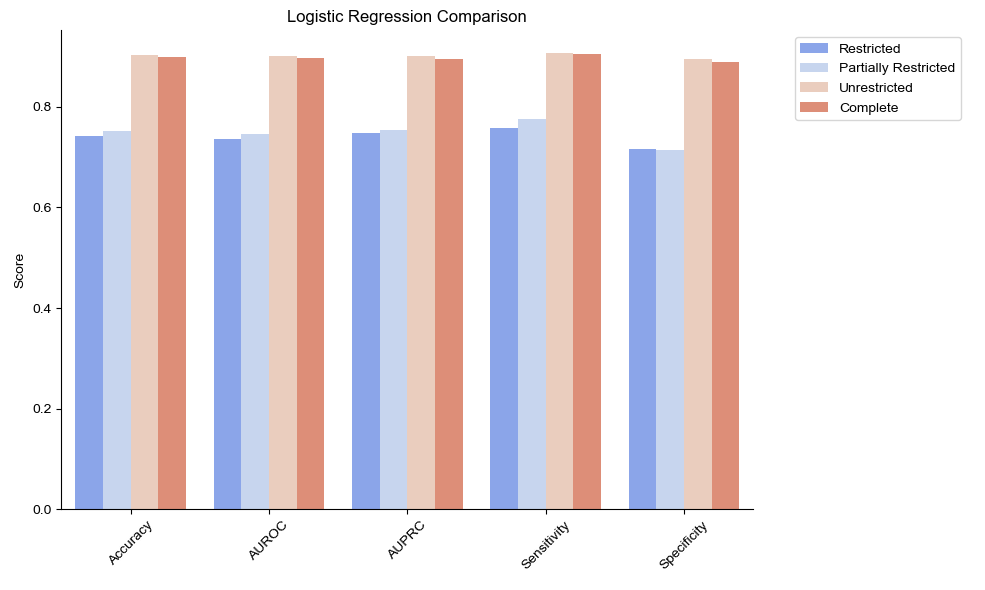

In [12]:
colors = sns.color_palette("coolwarm", len(subsets))

values = [lr_accuracy, lr_auroc, lr_aucpr, lr_sensitivity, lr_specificity]

variables = {"Subset": subsets}
for metric, metric_values in zip(metrics, values):
    variables[metric] = metric_values
metrics_df = pd.DataFrame(variables)

metrics_melted = metrics_df.melt(id_vars="Subset", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Subset", palette=colors)
plt.title("Logistic Regression Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.set_style("whitegrid")
sns.despine()
plt.show()

## Naive Bayes Results

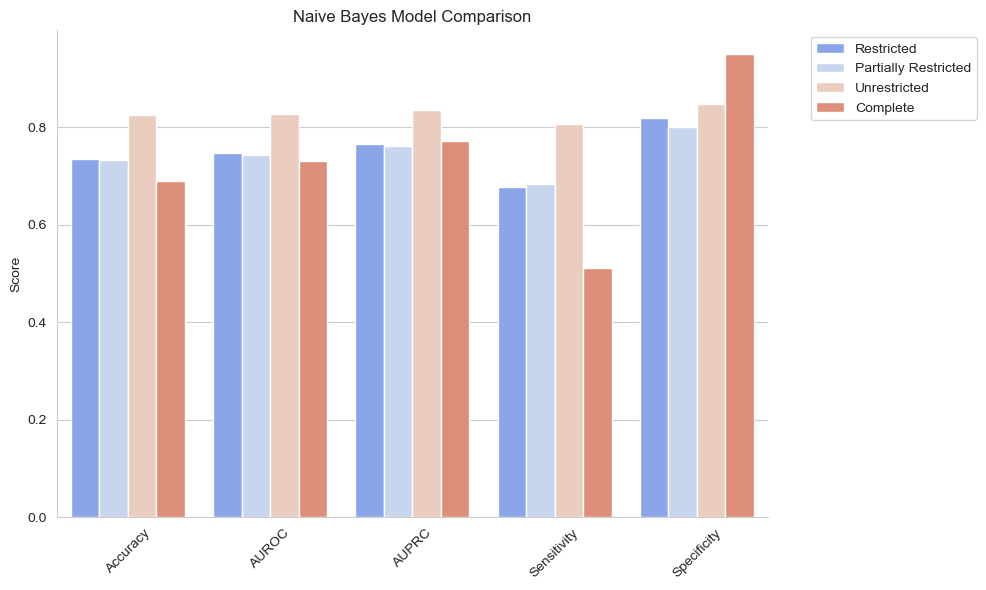

In [13]:
colors = sns.color_palette("coolwarm", len(subsets))

values = [nb_accuracy, nb_auroc, nb_aucpr, nb_sensitivity, nb_specificity]

variables = {"Subset": subsets}
for metric, metric_values in zip(metrics, values):
    variables[metric] = metric_values
metrics_df = pd.DataFrame(variables)

metrics_melted = metrics_df.melt(id_vars="Subset", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Subset", palette=colors)
plt.title("Naive Bayes Model Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.set_style("whitegrid")
sns.despine()
plt.show()

## SVM Results

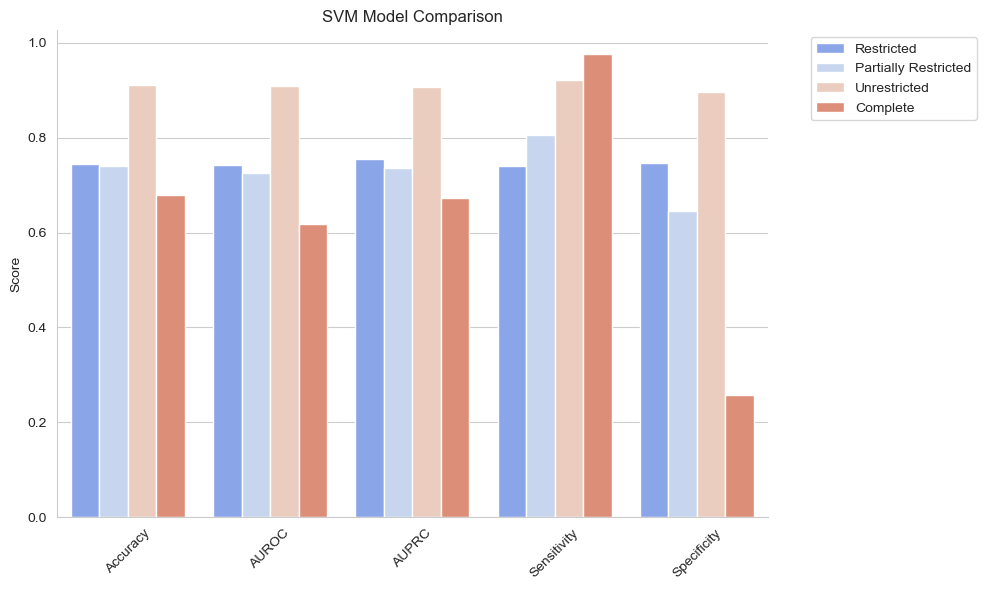

In [14]:
colors = sns.color_palette("coolwarm", len(subsets))

values = [svm_accuracy, svm_auroc, svm_aucpr, svm_sensitivity, svm_specificity]

variables = {"Subset": subsets}
for metric, metric_values in zip(metrics, values):
    variables[metric] = metric_values
metrics_df = pd.DataFrame(variables)

metrics_melted = metrics_df.melt(id_vars="Subset", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Subset", palette=colors)
plt.title("SVM Model Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.set_style("whitegrid")
sns.despine()
plt.show()

## Random Forest Results

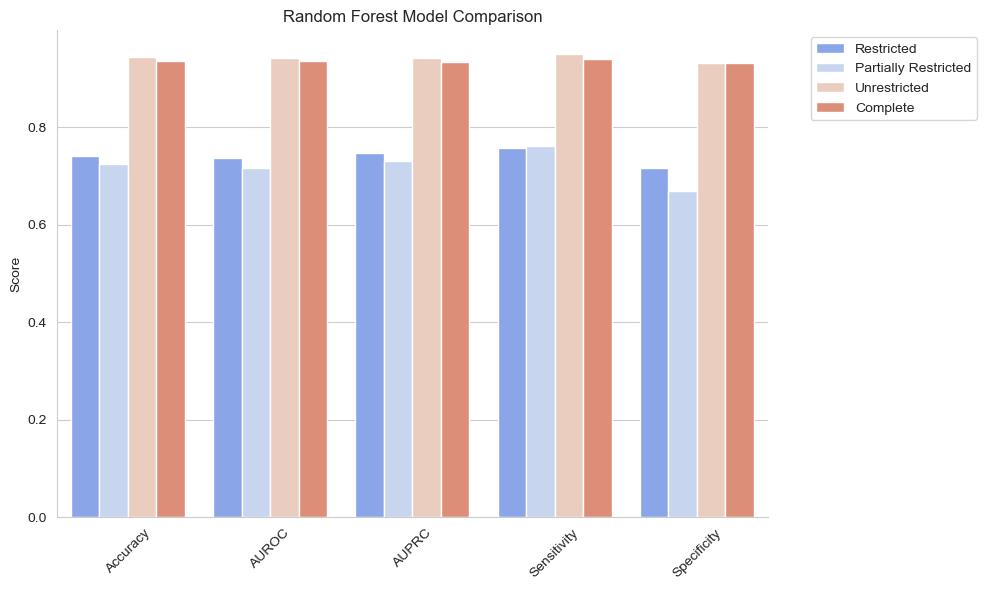

In [15]:
colors = sns.color_palette("coolwarm", len(subsets))

values = [rf_accuracy, rf_auroc, rf_aucpr, rf_sensitivity, rf_specificity]

variables = {"Subset": subsets}
for metric, metric_values in zip(metrics, values):
    variables[metric] = metric_values
metrics_df = pd.DataFrame(variables)

metrics_melted = metrics_df.melt(id_vars="Subset", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Subset", palette=colors)
plt.title("Random Forest Model Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.set_style("whitegrid")
sns.despine()
plt.show()

## Gradient Boosting Results

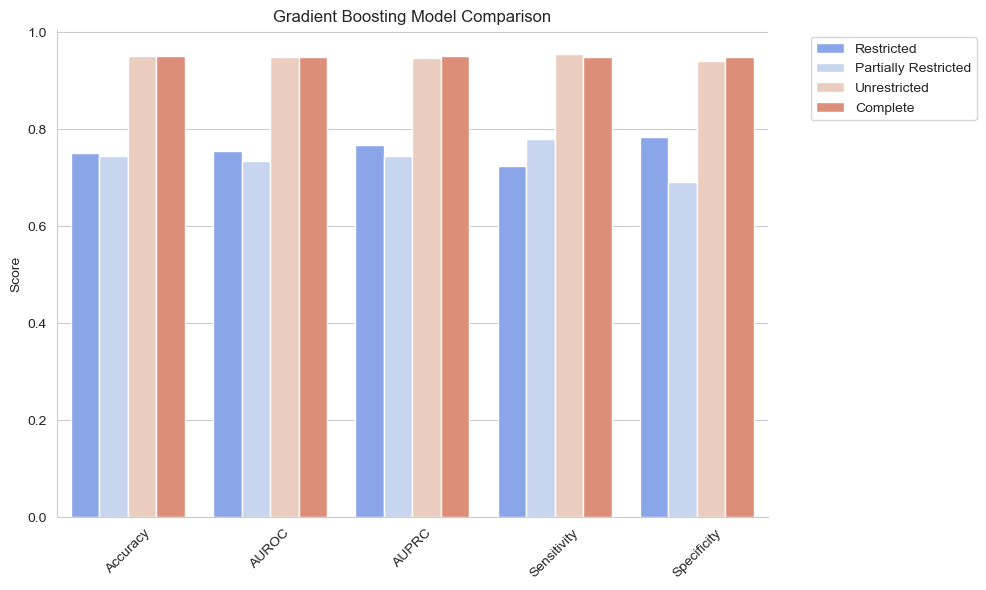

In [16]:
colors = sns.color_palette("coolwarm", len(subsets))

values = [gb_accuracy, gb_auroc, gb_aucpr, gb_sensitivity, gb_specificity]

variables = {"Subset": subsets}
for metric, metric_values in zip(metrics, values):
    variables[metric] = metric_values
metrics_df = pd.DataFrame(variables)

metrics_melted = metrics_df.melt(id_vars="Subset", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Subset", palette=colors)
plt.title("Gradient Boosting Model Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.set_style("whitegrid")
sns.despine()
plt.show()

## Neural Network Results

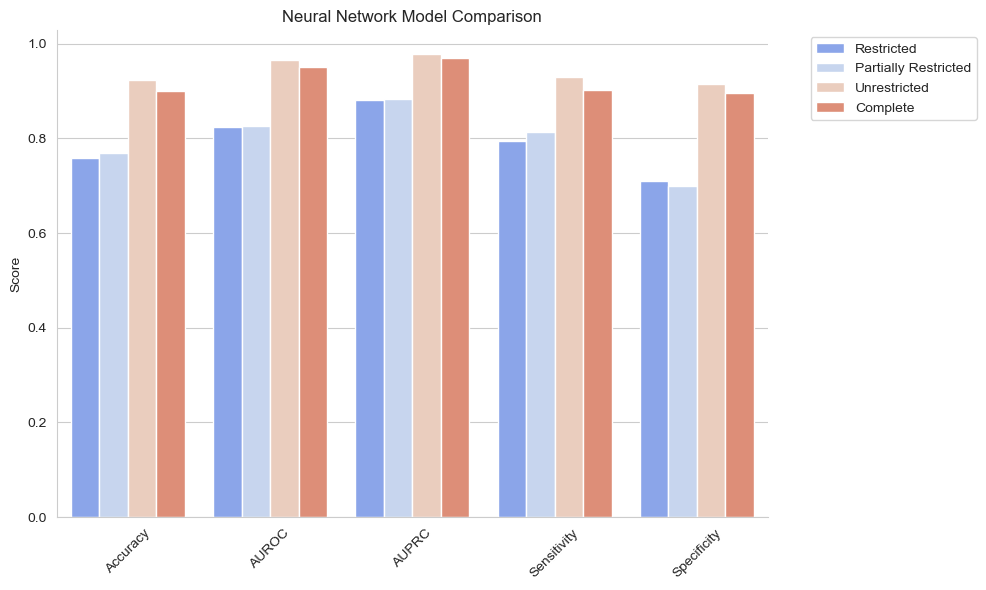

In [17]:
colors = sns.color_palette("coolwarm", len(subsets))

values = [nn_accuracy, nn_auroc, nn_aucpr, nn_sensitivity, nn_specificity]

variables = {"Subset": subsets}
for metric, metric_values in zip(metrics, values):
    variables[metric] = metric_values
metrics_df = pd.DataFrame(variables)

metrics_melted = metrics_df.melt(id_vars="Subset", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Subset", palette=colors)
plt.title("Neural Network Model Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.set_style("whitegrid")
sns.despine()
plt.show()

## Comparison of all Models

In [18]:
# Creating dataframe
index = pd.MultiIndex.from_product([subsets, metrics], names=['Subset', 'Metric'])
df = pd.DataFrame(index=index, columns=models)

lr_results = np.round(lr_results, 2)
nb_results = np.round(nb_results, 2)
svm_results = np.round(svm_results, 2)
rf_results = np.round(rf_results, 2)
gb_results = np.round(gb_results, 2)
nn_results = np.round(nn_results, 2)

df["Logistic Regression"] = lr_results
df["Naive Bayes"] = nb_results
df["SVM"] = svm_results
df["Random Forest"] = rf_results
df["GBM"] = gb_results
df["Neural Network"] = nn_results

df

Logistic Regression  Naive Bayes   SVM  Random Forest   GBM  Neural Network
Subset               Metric                                                                                  
Restricted           Accuracy                    0.74         0.74  0.74           0.74  0.75            0.76
                     AUROC                       0.74         0.75  0.74           0.74  0.75            0.82
                     AUPRC                       0.75         0.76  0.76           0.75  0.77            0.88
                     Sensitivity                 0.76         0.68  0.74           0.76  0.72            0.79
                     Specificity                 0.72         0.82  0.75           0.72  0.78            0.71
Partially Restricted Accuracy                    0.75         0.73  0.74           0.73  0.74            0.77
                     AUROC                       0.75         0.74  0.73           0.72  0.74            0.83
                     AUPRC                       0.75         0.76  0.74           0.73  0.75            0.88
                     Sensitivity                 0.78         0.68  0.80           0.76  0.78            0.81
                     Specificity                 0.71         0.80  0.65           0.67  0.69            0.70
Unrestricted         Accuracy                    0.90         0.82  0.91           0.94  0.95            0.92
                     AUROC                       0.90         0.83  0.91           0.94  0.95            0.97
                     AUPRC                       0.90         0.84  0.91           0.94  0.95            0.98
                     Sensitivity                 0.91         0.81  0.92           0.95  0.96            0.93
                     Specificity                 0.89         0.85  0.90           0.93  0.94            0.91
Complete             Accuracy                    0.90         0.69  0.68           0.94  0.95            0.90
                     AUROC                       0.90         0.73  0.62           0.94  0.95            0.95
                     AUPRC                       0.90         0.77  0.67           0.93  0.95            0.97
                     Sensitivity                 0.91         0.51  0.98           0.94  0.95            0.90
                     Specificity                 0.89         0.95  0.26           0.93  0.95            0.90